# 【課題】量子ダイナミクスシミュレーション・続

第三回の実習では量子計算の並列性と、その顕著な利用法としての量子ダイナミクスシミュレーションを取り上げました。また、実機で計算を行う際の実用的な問題として、回路の最適化や測定エラーの緩和についても議論しました。この課題はその直接の延長です。

```{contents} 目次
---
local: true
---
```
$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\plusket}{\ket{+}}$
$\newcommand{\minusket}{\ket{-}}$

## 問題1: ハイゼンベルグモデル、X方向のスピン

### 問題

実習ではハイゼンベルグモデルのシミュレーションをし、各スピンの$Z$方向の期待値の時間発展を追いました。しかし、シミュレーションそのものは最終的なオブザーバブル（観測量）によらず成立するので、（ほぼ）同じ回路を用いて系の他の性質を調べることもできます。そこで、各スピンの$X$方向の期待値の時間発展を測定する回路を書き、実習時と同様に時間に対してプロットしてください。

**ヒント**:

[プロット用関数`plot_heisenberg_spins`](https://github.com/UTokyo-ICEPP/qc-workbook/blob/master/source/utils/dynamics.py)で厳密解のカーブを書くとき、追加の引数`spin_component='x'`を渡すと$X$方向のスピンのプロットに切り替わります。ただし、実験結果の`counts_list`は相応する測定の結果となっていなければいけません。具体的には、各スピンについて「0が測定される＝スピンが+$X$を向いている、1が測定される＝スピンが-$X$を向いている」という対応付けが必要です。）

In [1]:
# 必要なモジュールを先にインポート
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
# このワークブック独自のモジュール
from qc_workbook.dynamics import plot_heisenberg_spins, bit_expectations_sv, bit_expectations_counts, diagonalized_evolution

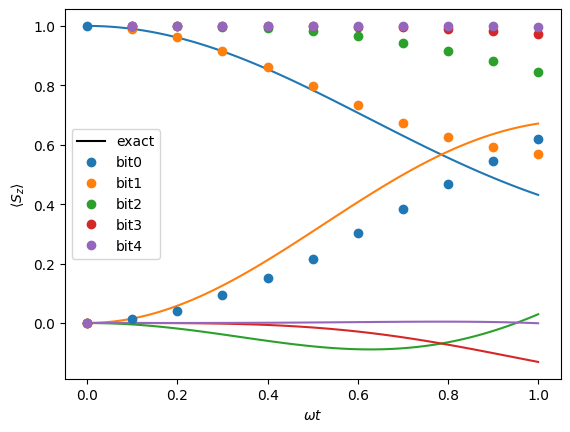

In [2]:
n = 5
M = 10
omegadt = 0.1

shots = 100000

# Define the circuits
circuits = []

circuit = QuantumCircuit(n)

# Bit 0 in state 1/sqrt(2)(|0> + |1>)
circuit.h(0)

for istep in range(M):
    for j in range(n - 1):
        # ZZ
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)

        # XX
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)

        # YY
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., j + 1)

    # Copy of the circuit up to this point
    snapshot = circuit.copy()

    ##################
    ### EDIT BELOW ###
    ##################

    # Set up the observable for this snapshot
    #snapshot.?

    ##################
    ### EDIT ABOVE ###
    ##################

    snapshot.measure_all()
    circuits.append(snapshot)

simulator = AerSimulator()

circuits = transpile(circuits, backend=simulator)
sim_job = simulator.run(circuits, shots=shots)
sim_counts_list = sim_job.result().get_counts()

# Initial state as a statevector
initial_state = np.zeros(2 ** n, dtype=np.complex128)
initial_state[0:2] = np.sqrt(0.5)

plot_heisenberg_spins(sim_counts_list, n, initial_state, omegadt, add_theory_curve=True, spin_component='x')

**提出するもの**

- 完成した回路のコードとシミュレーション結果によるプロット
- 一般の方向のスピンの期待値を測定するためにはどうすればいいかの説明

### おまけ: スピン総和

注：これは量子コンピューティングというより物理の問題なので、興味のある方だけ考えてみてください。

上のハイゼンベルグモデルのシミュレーションで、初期状態の$X$, $Y$, $Z$方向のスピン期待値の全系での平均値$m_x$, $m_y$, $m_z$はそれぞれ

$$
m_x = \frac{1}{n} \sum_{j=0}^{n} \langle \sigma^{X}_j \rangle = \frac{1}{n} \\
m_y = \frac{1}{n} \sum_{j=0}^{n} \langle \sigma^{Y}_j \rangle = 0 \\
m_z = \frac{1}{n} \sum_{j=0}^{n} \langle \sigma^{Z}_j \rangle = \frac{n-1}{n}
$$

です。これらの平均値はどう時間発展するでしょうか。理論的議論をし、シミュレーションで数値的に確かめてください。

## 問題2: シュウィンガーモデル

これまで扱ったような、スピンに関連する現象とは異なる物理モデルのシミュレーションをしましょう。空間1次元、時間1次元の時空における量子電磁力学の模型「シュウィンガーモデル」を考えます。

### シュウィンガーモデルの物理

簡単に物理の解説をします（ここは読み飛ばしても差し支えありません）。といっても、まともにゼロから解説をしたらあまりにも長くなってしまうので、かなり前提知識を仮定します。興味のある方は参考文献{cite}`shifman_schwinger,Martinez_2016`などを参照してください。特に{cite}`Martinez_2016`は実際にこれから実装する回路をイオントラップ型量子コンピュータで実行した論文です。

量子電磁力学とは量子場の理論の一種です。量子場の理論とは物質やその相互作用（力）をすべて量子力学的な「場」（時空中の各点に応じた値を持つ存在）で記述した理論で、素粒子論などで物質の根源的な性質を記述する際の基本言語です。量子場の理論において、一部の場を「物質場」とし、それに特定の対称性（$U(1)$ゲージ対称性）を持たせると、「電荷」が生み出され、電荷を持った場の間の相互作用を媒介する「光子場」が生じます。電荷を持った場と光子場の振る舞いを記述するのが量子電磁力学です。

量子場の理論は「ラグランジアン」[^lagrangian]を指定すれば定まります。シュウィンガーモデルのラグランジアンは物質場（電子）$\psi$とゲージ場（光子）$A$からなり、

```{math}
:label: schwinger_lagrangian
\mathcal{L} = -\frac{1}{4g^2} F^{\mu\nu}F_{\mu\nu} + \bar{\psi} (i\gamma^{\mu}D_{\mu} - m) \psi
```

です。ただし、これまでの物理系を扱った話と異なり、ここでは場の量子論の一般慣習に従って、光速$c$とプランク定数$\hbar$がともに1である単位系を使っています。

式{eq}`schwinger_lagrangian`の指数$\mu, \nu$は0（時間次元）か1（空間次元）の値を取ります。$\frac{1}{2g} F_{\mu\nu}$は$A$の強度テンソル（電場）で

$$
F_{\mu\nu} = \partial_{\mu} A_{\nu} - \partial_{\nu} A_{\mu}
$$

です。$\psi$は物質と反物質を表す2元スピノルで、$m$がその質量となります。$\{\gamma^0, \gamma^1\}$は2次元のクリフォード代数の表現です。

このラグランジアンを元に、Kogut-Susskindの手法{cite}`PhysRevD.10.732`でモデルを空間格子（格子間隔$a$）上の場の理論に移すと、そのハミルトニアンは

```{math}
:label: kogut_susskind_hamiltonian
H = \frac{1}{2a} \bigg\{ -i \sum_{j=0}^{n-2} \left[ \Phi^{\dagger}_{j} e^{i\theta_{j}} \Phi_{j+1} + \Phi_{j} e^{-i\theta_{j}} \Phi^{\dagger}_{j+1} \right] + 2 J \sum_{j=0}^{n-2} L_{j}^2 + 2 \mu \sum_{j=0}^{n-1} (-1)^{j+1} \Phi^{\dagger}_{j} \Phi_{j} \bigg\}
```

となります。ここで$J = g^2 a^2 / 2$, $\mu = m a$, また$\Phi_j$はサイト$j$上の（1元）物質場、$\theta_j$は$j$上のゲージ場、$L_j$は格子$j$と$j+1$間の接続上の電場です。

Kogut-Susskindハミルトニアンにおける物質場はstaggered fermionsと呼ばれ、隣接サイトのうち片方が物質を、もう一方が反物質を表します。約束として、ここでは$j$が偶数のサイトを物質（電荷-1）に、奇数のサイトを反物質（電荷1）に対応付けます。一般に各サイトにおける物質の状態は、フェルミ統計に従って粒子が存在する・しないという2つの状態の重ね合わせです。サイト$j$の基底$\plusket_j$と$\minusket_j$を、$\Phi_j$と$\Phi^{\dagger}_j$が

```{math}
:label: creation_annihilation
\Phi_j \plusket_j = \minusket_j \\
\Phi_j \minusket_j = 0 \\
\Phi^{\dagger}_j \plusket_j = 0 \\
\Phi^{\dagger}_j \minusket_j = \plusket_j
```

と作用する状態と定めます。質量項の符号から、偶数サイトでは$\minusket$が粒子が存在する状態、$\plusket$が存在しない状態を表現し、奇数サイトでは逆に$\plusket$が粒子あり、$\minusket$が粒子なしを表すことがわかります。つまり、$\Phi^{\dagger}_j$と$\Phi_j$はサイト$j$における電荷の上昇と下降を引き起こす演算子です。

### ハミルトニアンを物質場のみで記述する

$\newcommand{\flhalf}[1]{\left\lfloor \frac{#1}{2} \right\rfloor}$

このままのハミルトニアンではまだデジタルモデルが構築しにくいので、ゲージを固定して$\theta$と$L$を除いてしまいます[^another_approach]。まず$\Phi_j$を以下のように再定義します。

$$
\Phi_j \rightarrow \prod_{k=0}^{j-1} e^{-i\theta_{k}} \Phi_j.
$$

また、ガウスの法則から、サイト$j$の電荷$\rho_j$が同じサイトの電場の発散と等しいので、

$$
L_j - L_{j-1} = \rho_j \\
\therefore L_j = \sum_{k=0}^{j} \rho_k
$$

となります。ただし、サイト0に系の境界の外から作用する電場はないもの（$L_{-1} = 0$）としました。

質量項と同様にサイトの偶奇を考慮した電荷は

$$
\rho_k = \Phi_{k}^{\dagger} \Phi_{k} - (k+1 \bmod 2)
$$

なので、

$$
L_j = \sum_{k=0}^{j} \Phi_{k}^{\dagger} \Phi_{k} - \flhalf{j} - 1
$$

となります。ここで$\flhalf{j}$は切り捨ての割り算$[j - (j \bmod 2)]/2$（Pythonでの`j // 2`と同等）です。この電場を式{eq}`kogut_susskind_hamiltonian`に代入して

$$
H = \frac{1}{2a} \left\{ -i \sum_{j=0}^{n-2} \left[ \Phi^{\dagger}_{j} \Phi_{j+1} + \Phi_j \Phi^{\dagger}_{j+1} \right] + 2J \sum_{j=0}^{n-2} \left[\sum_{k=0}^{j} \Phi_{k}^{\dagger} \Phi_{k} - \flhalf{j} - 1 \right]^2 + 2\mu \sum_{j=0}^{n-1} (-1)^{j+1} \Phi^{\dagger}_{j} \Phi_{j} \right\}
$$

が得られます。

### ハミルトニアンをパウリ行列で表現する

最後に、$\plusket$と$\minusket$をスピン$\pm Z$の状態のようにみなして、$\Phi^{\dagger}_j\Phi_j$と$\Phi^{\dagger}_j\Phi_{j+1}$をパウリ行列で表現します。式{eq}`creation_annihilation`から
前者は

$$
\Phi^{\dagger}_j\Phi_j \rightarrow \frac{1}{2} (\sigma^Z_j + 1)
$$

と表現できることがわかります。一方、$\Phi^{\dagger}_j\Phi_{j+1}$に関しては、やや込み入った議論{cite}`PhysRevD.13.1043`の末、

$$
\Phi^{\dagger}_j\Phi_{j+1} \rightarrow i \sigma^-_{j+1} \sigma^+_{j}
$$

が正しい表現であることがわかっています。ここで、

$$
\sigma^{\pm} = \frac{1}{2}(\sigma^X \pm i \sigma^Y)
$$

です。また、このワークブックでの約束に従って、右辺の$j$と$j+1$の順番をひっくり返してあります。ハミルトニアンには$\Phi_j\Phi^{\dagger}_{j+1} \rightarrow i \sigma^+_{j+1}\sigma^-_{j}$も登場するので、二つの項を合わせると

$$
\Phi^{\dagger}_{j} \Phi_{j+1} + \Phi_j \Phi^{\dagger}_{j+1} \rightarrow \frac{i}{2} (\sigma^X_{j+1}\sigma^X_j + \sigma^Y_{j+1}\sigma^Y_j)
$$

となります。まとめると、

$$
H \rightarrow \frac{1}{4a} \left\{ \sum_{j=0}^{n-2} (\sigma^X_{j+1}\sigma^X_j + \sigma^Y_{j+1}\sigma^Y_j) + J \sum_{j=1}^{n-2} (n - j - 1) \sum_{k=0}^{j-1} \sigma^Z_j \sigma^Z_k + \sum_{j=0}^{n-1} \left[ (-1)^{j+1} \mu - J \flhalf{n-j} \right] \sigma^Z_j \right\}
$$

です。ただし、計算過程で現れる定数項（恒等演算子に比例する項）は時間発展において系の状態に全体位相をかける作用しか持たないため、無視しました。

### 問題

上のシュウィンガーモデルのハミルトニアンによる時間発展シミュレーションを、$\plusket$と$\minusket$をそれぞれ$\ket{0}$と$\ket{1}$に対応させて、8ビット量子レジスタに対して実装してください。初期状態は真空、つまりどのサイトにも粒子・反粒子が存在しない状態$\ket{+-+-+-+-}$とし、系全体の粒子数密度の期待値

$$
\nu = \left\langle \frac{1}{n} \sum_{j=0}^{n-1} \frac{1}{2} \left[(-1)^{j+1} \sigma^Z_j + 1\right] \right\rangle
$$

を時間の関数としてプロットしてください。余裕があれば、各サイトにおける粒子数、電荷、サイト間の電場などの期待値の時間変化も観察してみましょう。

ハミルトニアンのパラメターは、$J = 1$, $\mu = 0.5$とします（他の$J$や$\mu$の値もぜひ試してみてください）。$\omega = 1/(2a)$とおき、鈴木・トロッター分解における時間ステップ$\Delta t$の大きさ$\omega \Delta t = 0.2$として、時間$\omega t = 2$までシミュレーションをします。

**解説**:

偶数サイトでは$\plusket$が物質粒子の存在しない状態、奇数サイトでは$\minusket$が反物質粒子の存在しない状態を表すので、初期状態は粒子数密度0となります。しかし、場の量子論においては場の相互作用によって物質と反物質が対生成・対消滅を起こし、一般に系の粒子数の期待値は時間とともに変化します。

**ヒント**:

上のハミルトニアンのパラメターの値は参考文献{cite}`Martinez_2016`と同一です（ただし$\sigma$積の順番は逆です）。したがって、$n=4$, $\omega \Delta t = \pi/8$とすれば、論文中の図3aを再現できるはずです。答え合わせに使ってください。

また、問題を解くためのヒントではありませんが、ハイゼンベルグモデルと同様にこのモデルでも対角化による厳密解を比較的簡単にプロットできるように道具立てがしてあります。下のコードのテンプレートでは、シミュレーション回路と厳密解を計算するためのハミルトニアンのパウリ行列分解だけ指定すれば、`plot_heisenberg_spins`と同様のプロットが作成されるようになっています。パウリ行列分解を指定するには、`paulis`と`coeffs`という二つのリストを作り、Qiskitの`SparsePauliOp`というクラスに渡します。これらのリストの長さはハミルトニアンの項数で、`paulis`の各要素は対応する項のパウリ行列のリスト、`coeffs`の各要素はその項にかかる係数にします。例えば

$$
H = 0.5 \sigma^X_2 \sigma^Y_1 I_0 + I_2 \sigma^Z_1 \sigma^X_0
$$

というハミルトニアンに対しては、

```{code-block} python
paulis = ['XYI', 'IZX']
coeffs = [0.5, 1.]
```

です。

[^lagrangian]: ここで「ラグランジアン」と呼ばれているのは本来「ラグランジアン密度」で、正しくはこれを空間積分したものがラグランジアンですが、素粒子論の文脈で「ラグランジアン」と言った場合はほぼ100%積分する前のものを指します。
[^another_approach]: 参考文献{cite}`Shaw2020quantumalgorithms`では、別のアプローチで同じハミルトニアンの量子回路実装をしています。

In [3]:
def number_density(bit_exp):
    particle_number = np.array(bit_exp) # shape (T, n)
    # Particle number is 1 - (bit expectation) on odd sites
    particle_number[:, 1::2] = 1. - particle_number[:, 1::2]

    return np.mean(particle_number, axis=1)


n = 8 # number of sites
J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

## Quantum circuit experiment

M = 10 # number of Trotter steps
omegadt = 0.2 # Trotter step size

shots = 100000

# Define the circuits
circuits = []

circuit = QuantumCircuit(n)

# Initial state = vacuum
circuit.x(range(1, n, 2))

for istep in range(M):
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    circuits.append(circuit.measure_all(inplace=False))

# Run the circuits in the simulator
simulator = AerSimulator()

circuits = transpile(circuits, backend=simulator)
sim_job = simulator.run(circuits, shots=shots)
sim_counts_list = sim_job.result().get_counts()

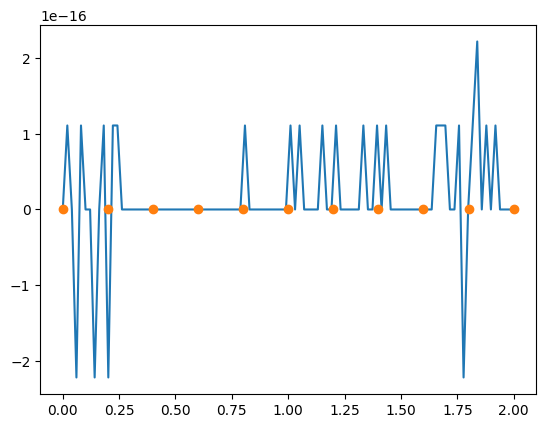

In [4]:
## Numerical solution through diagonalization

##################
### EDIT BELOW ###
##################

paulis = ['I' * n]
coeffs = [1.]

##################
### EDIT ABOVE ###
##################

hamiltonian = SparsePauliOp(paulis, coeffs).to_matrix()

# Initial state as a statevector
initial_state = np.zeros(2 ** n, dtype=np.complex128)
vacuum_state_index = 0
for j in range(1, n, 2):
    vacuum_state_index += (1 << j)
initial_state[vacuum_state_index] = 1.

## Plotting

# Plot the exact solution
time_points, statevectors = diagonalized_evolution(hamiltonian, initial_state, omegadt * M)
_, bit_exp = bit_expectations_sv(time_points, statevectors)

plt.plot(time_points, number_density(bit_exp))

# Prepend the "counts" (=probability distribution) for the initial state to counts_list
initial_probs = np.square(np.abs(initial_state))
fmt = f'{{:0{n}b}}'
initial_counts = dict((fmt.format(idx), prob) for idx, prob in enumerate(initial_probs) if prob != 0.)
sim_counts_list_with_init = [initial_counts] + sim_counts_list

# Plot the simulation results
time_points = np.linspace(0., omegadt * M, M + 1, endpoint=True)
_, bit_exp = bit_expectations_counts(time_points, sim_counts_list_with_init, n)

plt.plot(time_points, number_density(bit_exp), 'o')

**提出するもの**

- 完成した回路のコードとシミュレーション結果によるプロット